### Implicit solution of Hodgin Huxley equations for a spherical cell
The rate equations are solved using the implicit trapezoid method. Because the HH equations were developed for ms time units and mV voltage, time is kept in ms throughout and voltage is converted to mV within the procedure calculating the HH rates.

The backward Euler method is used to solve the voltage equation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Define cell parameters


In [ ]:
diameter = 40                 # um   
A = 4*np.pi*(diameter/2)**2   # µm^2 membrane area
cm_bar = 0.01 *1e-12          # F/µm^2, specific capacitance, 0.01 pF/µm^2

gL_bar = 3.0 *1e-12      # S/µm^2, specific leak conductance, 3 pS/µm^2
VL = -65 *1e-3           # V, reversal potential for leak conductance 

ENa = 50 *1e-3           # V, Na reversal potential
EK = -77 *1e-3           # V, K reversal potential
gNa_bar = 1200 *1e-12    # S/um^2, Na conductance, 1200 pS/um^2
gK_bar = 360 *1e-12      # S/um^2, K conductance, 360 pS/um^2 

Vrest = -68.57404183502005 *1e-3    # V, initial resting membrane potential

# Temperature parameters
T_C = 18.5      # temperature C, 18.5*C
Q10 = 3**((T_C - 6.3)/10)

Calculate cell specific values

In [ ]:
Cm = cm_bar*A    # F
GL = gL_bar*A    # S
GNa = gNa_bar*A  # S
GK = gK_bar*A    # S

print("Area =", round(A), "um^2")
print('Cm =', round(Cm*1e12,1), 'pF')
print('GL =', round(GL*1e9,1), 'nS')
print('GNa =', round(GNa *1e9,1), 'nS')
print('GK =', round(GK*1e9,1), 'nS')

Area = 5027 um^2
Cm = 50.3 pF
GL = 15.1 nS
GNa = 6031.9 nS
GK = 1809.6 nS


Simulation parameters

In [ ]:
Tend = 6                        # duration of simulation ms
dt = 0.01                       # time step ms
td = 1/dt                       # inverse time step used to update state variables
t = np.arange(0, Tend+dt, dt)   # time vector
Nt = len(t)-1                   # number of time steps    

Stimulation protocol

In [ ]:
# Stimulus parameters for current step
t1 = 1          # 5 ms, start of current pulse 
t2 = 1.3        # 30 ms, end of current pulse 
amp = 3 *1e-9   # 3 nA, amplitude of current pulse, 

# Create stimulus vector with current injection starting at time t1 and ending at time t2
Nt1 = round(t1/dt)+1
Nt2 = round(t2/dt)
Istim = np.zeros(Nt+1)  
Istim[Nt1:Nt2] = amp  # add current to stimulus vector

Create and initialize voltage, state, conductance and current matrices

In [ ]:
V = np.zeros(Nt+1)
n = np.zeros(Nt+1)
m = np.zeros(Nt+1)
h = np.zeros(Nt+1)
gNa = np.zeros(Nt+1)
gK = np.zeros(Nt+1)
INa = np.zeros(Nt+1)
IK = np.zeros(Nt+1)

Calculates HH kinetic rates for a given voltage and temperature. Assumes mV for voltage so have to convert. Output is rate/ms. 

In [ ]:
def Rates(V, Q10):
  V = V*1e3 # convert voltage to mV
  
  an = 0.01 * (V + 55) / (1 - np.exp(-(V + 55)/10)) * Q10
  bn = 0.125 * np.exp(-(V + 65)/80) * Q10
  am = 0.1 * (V + 40) / (1 - np.exp(-(V + 40)/10)) * Q10
  bm = 4 * np.exp(-(V + 65)/18) * Q10
  ah = 0.07 * np.exp(-(V + 65)/20) * Q10
  bh = 1 / (1 + np.exp(-(V + 35)/10)) * Q10
  return an, bn, am, bm, ah, bh

Initialize voltage, state and conductance values.

In [ ]:
V[0] = Vrest
an, bn, am, bm, ah, bh = Rates(V[0], Q10)
n[0] = an /(an + bn) 
m[0] = am /(am + bm) 
h[0] = ah /(ah + bh) 

Solve equations.

In [ ]:
dt = dt *1e-3 # convert ms to s
for j in range(0,Nt):
  # rates are per ms, and td is 1/ms
  # n, m, h are diminensionless
  an, bn, am, bm, ah, bh = Rates(V[j], Q10) 
  c = (an + bn)/2
  n[j+1] = ( (td - c)* n[j] + an ) / (td + c)
  c = (am + bm)/2
  m[j+1] = ( (td - c)* m[j] + am ) / (td + c)
  c = (ah + bh)/2
  h[j+1] = ( (td - c)* h[j] + ah ) / (td + c)

  # update V with half step backward Euler method 
  GKn4 = GK*n[j+1]**4 
  GNam3h = GNa*m[j+1]**3*h[j+1]
  numerator = V[j]*2*Cm/dt + Istim[j+1] + GL*VL + GKn4*EK + GNam3h*ENa
  denominator = 2*Cm/dt + GL + GKn4 + GNam3h
  Vhalf = numerator/denominator
  # linearly advance V one half step to t(j+1)
  V[j+1]= 2*Vhalf - V[j]

Calculate conductance and current values and convert units for plotting

In [ ]:
# calculate conductance and current in S and A
gK = GK*n**4        # S
gNa = GNa*m**3*h    # S
IK = gK*(V-EK)       # A
INa = gNa*(V-ENa)    # A

# convert units for plotting
V = V *1e3        # V to mV
gK = gK *1e6      # S to uS
gNa = gNa *1e6    # S to uS
IK = IK *1e9      # A to nA
INa = INa *1e9    # A to nA

Plot results

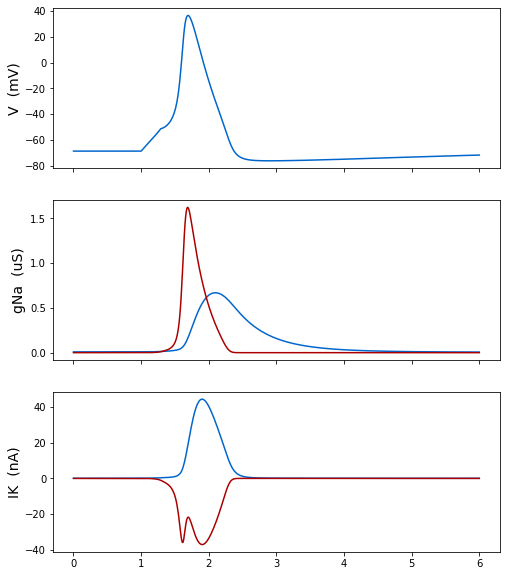

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 10]
f, axs = plt.subplots(3, gridspec_kw={'height_ratios': [1, 1, 1]}, sharex='all')

axs[0].plot(t,V, '#0066CC')
axs[0].set_ylabel('V  (mV)', fontsize=14)

axs[1].plot(t,gK, '#0066CC')
axs[1].set_ylabel('gK  (uS)', fontsize=14)

axs[1].plot(t,gNa, '#AA0000')
axs[1].set_ylabel('gNa  (uS)', fontsize=14)

axs[2].plot(t,IK, '#0066CC')
axs[2].set_ylabel('IK  (nA)', fontsize=14)

axs[2].plot(t,INa, '#AA0000')
axs[2].set_ylabel('IK  (nA)', fontsize=14)

plt.show() # suppresses return values